# Identificador de cabelos

# Autor
Nome: Samuel Nogueira Bacelar
Matrícula: 180130722
Github: [SamuelNoB](https://github.com/SamuelNoB)

# Objetivo

O objetivo deste artigo é o de criar um modelo capaz de reconhecer e diferenciar os principais tipos de cabelos existentes em ambos os sexos. Os principais tipos de cabelos são: Crespo, Ondulado, Liso e Cacheado.

## Passo 1: Baixar imagens de diferentes tipos de cabelos

In [9]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Iniciamos produrando por imagens de pessoas de cabelo crespo

In [10]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('coily hair male photos', max_images=3)
urls[2]


Searching for 'coily hair male photos'


'https://ath2.unileverservices.com/wp-content/uploads/sites/3/2016/05/curly-natural-hair-medium-black-mens.jpg'

Então baixamos uma imagem poder visualiza-la

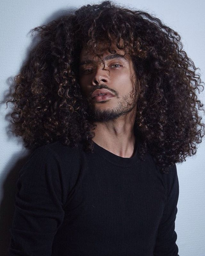

In [11]:
from fastdownload import download_url
dest = 'curly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Então procuramos pelos quatro tipos principais de cabelos, em ambos os sexos e com plano de fundo fora e dentro de um ambiente interno.

In [12]:
searches = 'straight','curly', 'wavy', 'coily'
path = Path('hair_types')
from time import sleep

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} hair photo'))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     download_images(dest, urls=search_images(f'{o} hair male photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} hair outdoor photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} hair male outdoor photo'))
#     sleep(10)
#     resize_images(path/o, max_size=600, dest=path/o)

## Passo 2: Treinando o modelo

Primeiro é necessário remover fotos que tiveram erros no momento do download de modo a não impactar o treinamento do modelo

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinar um modelo, precisaremos de `DataLoaders`, que é um objeto que contém um **conjunto de treinamento** (as imagens usadas para criar um modelo) e um **conjunto de validação** (as imagens usadas para verificar a precisão de um modelo - não usado durante o treinamento). No `fastai`, podemos criar isso facilmente usando um `DataBlock` e visualizar imagens de amostra a partir dele:

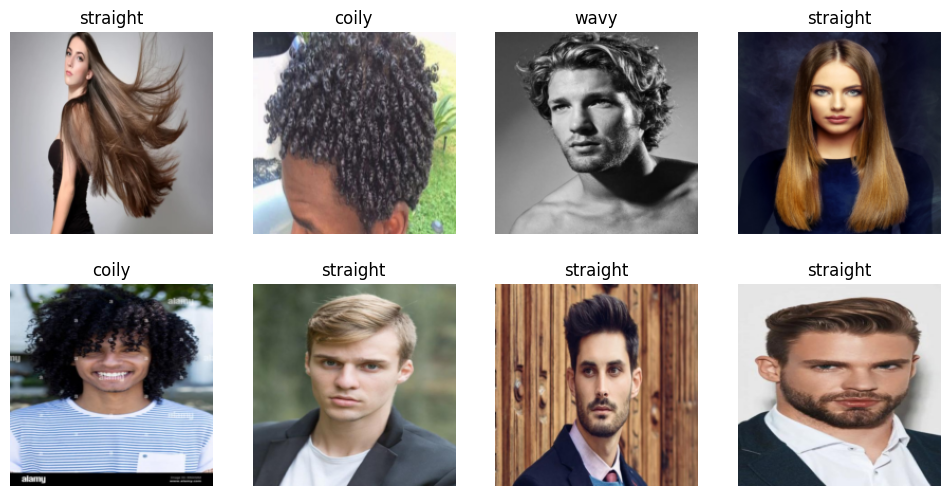

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32, pin_memory=False)

dls.show_batch(max_n=8)

Aqui está o que cada um dos parâmetros `DataBlock` significa:

    blocks=(ImageBlock, CategoryBlock),

As entradas para o nosso modelo são imagens e as saídas são categorias (neste caso, "pássaro" ou "floresta").

    get_items=get_image_files,

Para encontrar todas as entradas para o nosso modelo, execute a função `get_image_files` (que retorna uma lista de todos os arquivos de imagem em um caminho).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divida os dados em conjuntos de treinamento e validação aleatoriamente, usando 20% dos dados para o conjunto de validação.

    get_y=parent_label,

Os rótulos (valores `y`) são o nome do `pai` de cada arquivo (ou seja, o nome da pasta em que estão, que será *pássaro* ou *floresta*).

    item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensione cada imagem para 192x192 pixels "espremendo-a" (em vez de cortá-la).

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o `resnet50`. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O `fastai` vem com um método útil `fine_tune()` que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

### configurações adicionais
As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente.

In [15]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()


18826

In [16]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

### Treinando
Aqui treinamos nosso modelo com um total de 10 iterações.

In [22]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.478578,0.648899,0.150538,00:06
1,0.364076,0.668249,0.172043,00:06
2,0.310316,0.695201,0.172043,00:06
3,0.265746,0.679388,0.139785,00:06
4,0.214053,0.737272,0.139785,00:06
5,0.182641,0.784069,0.139785,00:06
6,0.156251,0.870091,0.172043,00:06
7,0.134088,0.820009,0.150538,00:06
8,0.112867,0.802331,0.150538,00:06
9,0.099836,0.803963,0.150538,00:06


Como visto acima obtemos uma taxa de erros de 15.05%.

## Passo 3: Testando o modelo

Com o modelo treinado, basta executar a última tela e será retornado um prompt informando qual é o tipo de cabelo da pessoa na foto, uma probabilidade de ser o tipo de cabelo predito e a imagem inserida.

In [18]:
translator = {
    "coily": "Crespo",
    "straight": "Liso",
    "curly": "Cacheado",
    "wavy": "Ondulado"
}

É um cabelo Cacheado.
Probabilidade de ser do tipo Cacheado: 97.57%


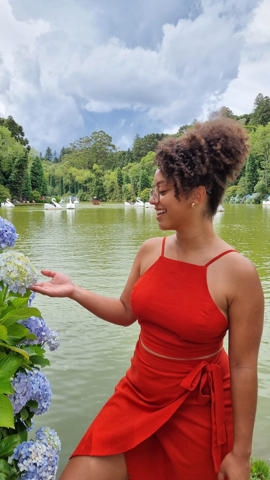

In [31]:
prediction_photo='coily.jpg'

hair_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É um cabelo {translator[hair_type]}.")
print(f"Probabilidade de ser do tipo {translator[hair_type]}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

# Conclusão
Como existem diversos "meio termos" de cabelos, classificar um tipo de cabelo em uma das quatro categorias propostas pode acabar gerando uma falta de acurácia por parte do modelo. Realizar a identificação de um cabelo liso para um não liso é fácil, entretanto quando entra no espéctro dos cabelos "ondulados" fica mais dificil distinguir um cabelo do outro. Isso justifica o porque da taxa de erros ser de 15%

Para aprimorar a acurácia do modelo foi necessário separar manualmente os dados usados para o treinamento. Nos primeiros treinamentos a taxa de erros chegava a ser maior que 27% e a separação manual melhorou a acurácia do modelo. Com isso, verifica-se que, a qualidade da classificação dos dados de treinamento impacta diretamente na assertividade do modelo.